In [93]:
# uncomment the following line to install required packages. I may have missed some.
#import Pkg; Pkg.add(["Flux", "Zygote", "CSV", "DataFrames", "Statistics", "ProgressMeter", "Plots"])

In [94]:
using Flux
using Zygote
using CSV
using DataFrames
using Statistics
using ProgressMeter
using Plots

In [95]:
nx = 2 # number of states
lr = 2e-3 # learning rate
iterations = 1000;

## Data preparation

In [96]:
df = CSV.read("cascaded_tanks.csv", DataFrame)
first(df, 5)

Row,uEst,uVal,yEst,yVal,Ts,Column6
,Float64,Float64,Float64,Float64,Int64?,Missing
1,3.2567,0.97619,5.205,4.9728,4,missing
2,3.2466,0.99921,5.2154,4.9722,missing,missing
3,3.2309,1.0172,5.2215,4.9703,missing,missing
4,3.2097,1.0318,5.2142,4.988,missing,missing
5,3.1836,1.0456,5.2001,4.9825,missing,missing


In [97]:
nu = 1 # number of inputs
ny = 1 # number of outputs
seq_len = length(df.yEst)

y_train = reshape(df.yEst, ny, seq_len) # reshape to 1 row and seq_len columns
u_train = reshape(df.uEst, nu, seq_len) 

y_test = reshape(df.yVal, ny, seq_len) # reshape to 1 row and seq_len columns
u_test = reshape(df.uVal, nu, seq_len) 

size(y_train), size(u_train)

((1, 1024), (1, 1024))

In [98]:
# Compute the mean and standard deviation for normalization
u_mean = mean(u_train)
u_std = std(u_train)
y_mean = mean(y_train)
y_std = std(y_train)

2.1661934355291974

In [99]:
# Normalize the training data
y = (y_train .- y_mean) ./ y_std;
u = (u_train .- u_mean) ./ u_std;

## Training

In [100]:
params = (
    A = randn(nx, nx)./10.0,
    B = randn(nx, nu)./10.0,
    C = randn(ny, nx)./10.0,
    x0 = randn(nx)
);

In [101]:
function lti_cell(p, xt, ut)
    x_new = p.A * xt + p.B * ut
    yt = p.C * xt
    return yt, x_new
end

lti_cell (generic function with 1 method)

In [102]:
function simulate(p, u; grads=false)
    xt = p.x0
    if grads
        y_hat = Zygote.Buffer(zeros(size(p.C, 1), size(u, 2)))  # mutable buffer
    else
        y_hat = zeros(size(p.C, 1), size(u, 2))  # normal array
    end

    for (t, ut) in enumerate(eachcol(u))
        yt, xt = lti_cell(p, xt, ut)
        y_hat[:, t] = yt
    end

    if grads
        return copy(y_hat)  # return the mutable buffer directly
    else
        return y_hat  # return the normal array
    end
end

simulate (generic function with 1 method)

In [103]:
function forward_loss(p, u, y)
    y_hat = simulate(p, u; grads=true)
    loss = sum((y .- y_hat).^2) / size(y_hat, 2)
    return loss
end

forward_loss (generic function with 1 method)

In [104]:
opt_state = Flux.setup(Flux.Adam(lr), params)  # initialize Adam's internal state for your params

(A = Leaf(Adam(eta=0.002, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], (0.9, 0.999))), B = Leaf(Adam(eta=0.002, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0; 0.0;;], [0.0; 0.0;;], (0.9, 0.999))), C = Leaf(Adam(eta=0.002, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0 0.0], [0.0 0.0], (0.9, 0.999))), x0 = Leaf(Adam(eta=0.002, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0, 0.0], [0.0, 0.0], (0.9, 0.999))))

In [105]:
losses = []
@showprogress for itr in 1:iterations
    loss, grads = Zygote.withgradient(params) do p
        forward_loss(p, u, y)
    end
    
    Flux.Optimise.update!(opt_state, params, grads[1])
    
    if itr % 10 == 0
       println("Epoch $itr, loss = $loss")
    end
    push!(losses, loss)
end


Progress:   1%|▍                                        |  ETA: 0:02:01

Epoch 10, loss = 1.0005167661768182


Progress:   2%|▊                                        |  ETA: 0:01:24

Epoch 20, loss = 0.9987062129445744


Progress:   3%|█▎                                       |  ETA: 0:01:03

Epoch 30, loss = 0.9967787921583147


Progress:   4%|█▌                                       |  ETA: 0:00:56

Epoch 40, loss = 0.9940136238587334


Progress:   5%|█▉                                       |  ETA: 0:00:52

Epoch 50, loss = 0.9897247892976452


Progress:   6%|██▍                                      |  ETA: 0:00:48

Epoch 60, loss = 0.9834509913139825


Progress:   7%|██▊                                      |  ETA: 0:00:45

Epoch 70, loss = 0.9750821995467002


Progress:   8%|███▎                                     |  ETA: 0:00:43

Epoch 80, loss = 0.9651956065027155


Progress:   9%|███▋                                     |  ETA: 0:00:42

Epoch 90, loss = 0.9556162515342976


Progress:  10%|████                                     |  ETA: 0:00:40

Epoch 100, loss = 0.949276371401163


Progress:  11%|████▍                                    |  ETA: 0:00:39

Epoch 110, loss = 0.9462254974672082


Progress:  12%|████▊                                    |  ETA: 0:00:38

Epoch 120, loss = 0.9411155240807814


Progress:  13%|█████▎                                   |  ETA: 0:00:37

Epoch 130, loss = 0.9311120460146405


Progress:  14%|█████▋                                   |  ETA: 0:00:36

Epoch 140, loss = 0.9084495390440679


Progress:  15%|██████                                   |  ETA: 0:00:35

Epoch 150, loss = 0.8277706981967634


Progress:  16%|██████▍                                  |  ETA: 0:00:35

Epoch 160, loss = 0.23822101671851473


Progress:  17%|██████▉                                  |  ETA: 0:00:34

Epoch 170, loss = 0.18498524596146085


Progress:  18%|███████▎                                 |  ETA: 0:00:34

Epoch 180, loss = 0.15541011238288335


Progress:  19%|███████▊                                 |  ETA: 0:00:33

Epoch 190, loss = 0.12794112434689658


Progress:  20%|████████▏                                |  ETA: 0:00:32

Epoch 200, loss = 0.12449243952092694


Progress:  21%|████████▋                                |  ETA: 0:00:32

Epoch 210, loss = 0.12458627633177416


Progress:  22%|█████████                                |  ETA: 0:00:31

Epoch 220, loss = 0.12325952841055228


Progress:  23%|█████████▍                               |  ETA: 0:00:31

Epoch 230, loss = 0.12272135508460234


Progress:  24%|█████████▊                               |  ETA: 0:00:30

Epoch 240, loss = 0.12248558708089406


Progress:  25%|██████████▎                              |  ETA: 0:00:29

Epoch 250, loss = 0.12224839150954729


Progress:  26%|██████████▋                              |  ETA: 0:00:29

Epoch 260, loss = 0.12200036634644242


Progress:  27%|███████████                              |  ETA: 0:00:28

Epoch 270, loss = 0.12175688074877329


Progress:  28%|███████████▌                             |  ETA: 0:00:28

Epoch 280, loss = 0.12151516047761399


Progress:  29%|███████████▊                             |  ETA: 0:00:27

Epoch 290, loss = 0.12127199991222297


Progress:  30%|████████████▎                            |  ETA: 0:00:27

Epoch 300, loss = 0.12102500417510764


Progress:  31%|████████████▋                            |  ETA: 0:00:26

Epoch 310, loss = 0.12077295925835253


Progress:  32%|█████████████                            |  ETA: 0:00:26

Epoch 320, loss = 0.1205148210082508


Progress:  33%|█████████████▍                           |  ETA: 0:00:26

Epoch 330, loss = 0.12024963005006861


Progress:  34%|█████████████▉                           |  ETA: 0:00:25

Epoch 340, loss = 0.11997644384658526


Progress:  35%|██████████████▎                          |  ETA: 0:00:25

Epoch 350, loss = 0.1196943275241975


Progress:  36%|██████████████▋                          |  ETA: 0:00:24

Epoch 360, loss = 0.11940234872678773


Progress:  37%|███████████████▏                         |  ETA: 0:00:24

Epoch 370, loss = 0.11909957240481835


Progress:  38%|███████████████▌                         |  ETA: 0:00:23

Epoch 380, loss = 0.1187850585422686


Progress:  39%|████████████████                         |  ETA: 0:00:23

Epoch 390, loss = 0.11845785959661426


Progress:  40%|████████████████▍                        |  ETA: 0:00:22

Epoch 400, loss = 0.11811701956633938


Progress:  41%|████████████████▋                        |  ETA: 0:00:22

Epoch 410, loss = 0.1177615740485793


Progress:  42%|█████████████████▏                       |  ETA: 0:00:22

Epoch 420, loss = 0.11739055096322694


Progress:  43%|█████████████████▌                       |  ETA: 0:00:21

Epoch 430, loss = 0.11700297219417934


Progress:  44%|██████████████████                       |  ETA: 0:00:21

Epoch 440, loss = 0.11659785610968243


Progress:  45%|██████████████████▍                      |  ETA: 0:00:20

Epoch 450, loss = 0.11617422090293665


Progress:  46%|██████████████████▉                      |  ETA: 0:00:20

Epoch 460, loss = 0.11573108884054127


Progress:  47%|███████████████████▏                     |  ETA: 0:00:20

Epoch 470, loss = 0.11526749146985502


Progress:  48%|███████████████████▌                     |  ETA: 0:00:19

Epoch 480, loss = 0.11478247581974425


Progress:  49%|████████████████████                     |  ETA: 0:00:19

Epoch 490, loss = 0.11427511166649118


Progress:  50%|████████████████████▌                    |  ETA: 0:00:18

Epoch 500, loss = 0.11374449992845607


Progress:  51%|████████████████████▊                    |  ETA: 0:00:18

Epoch 510, loss = 0.11318978224266785


Progress:  52%|█████████████████████▎                   |  ETA: 0:00:18

Epoch 520, loss = 0.11261015177637243


Progress:  53%|█████████████████████▋                   |  ETA: 0:00:17

Epoch 530, loss = 0.11200486531074558


Progress:  54%|██████████████████████                   |  ETA: 0:00:17

Epoch 540, loss = 0.1113732566126199


Progress:  55%|██████████████████████▌                  |  ETA: 0:00:16

Epoch 550, loss = 0.11071475108533137


Progress:  56%|██████████████████████▉                  |  ETA: 0:00:16

Epoch 560, loss = 0.11002888165478396


Progress:  57%|███████████████████████▍                 |  ETA: 0:00:16

Epoch 570, loss = 0.10931530580413401


Progress:  58%|███████████████████████▋                 |  ETA: 0:00:15

Epoch 580, loss = 0.1085738236200305


Progress:  59%|████████████████████████▏                |  ETA: 0:00:15

Epoch 590, loss = 0.10780439665367905


Progress:  60%|████████████████████████▍                |  ETA: 0:00:15

Epoch 600, loss = 0.10700716733245785


Progress:  61%|████████████████████████▉                |  ETA: 0:00:14

Epoch 610, loss = 0.10618247858323224


Progress:  62%|█████████████████████████▍               |  ETA: 0:00:14

Epoch 620, loss = 0.10533089324824817


Progress:  63%|█████████████████████████▊               |  ETA: 0:00:13

Epoch 630, loss = 0.10445321279124643


Progress:  64%|██████████████████████████▏              |  ETA: 0:00:13

Epoch 640, loss = 0.10355049470846463


Progress:  65%|██████████████████████████▋              |  ETA: 0:00:13

Epoch 650, loss = 0.10262406798077067


Progress:  66%|███████████████████████████              |  ETA: 0:00:12

Epoch 660, loss = 0.10167554583464225


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:12

Epoch 670, loss = 0.1007068350271929


Progress:  68%|███████████████████████████▊             |  ETA: 0:00:12

Epoch 680, loss = 0.09972014084082406


Progress:  69%|████████████████████████████▏            |  ETA: 0:00:11

Epoch 690, loss = 0.09871796697359897


Progress:  70%|████████████████████████████▋            |  ETA: 0:00:11

Epoch 700, loss = 0.09770310954924491


Progress:  71%|█████████████████████████████            |  ETA: 0:00:11

Epoch 710, loss = 0.09667864455226342


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:10

Epoch 720, loss = 0.09564790812403542


Progress:  73%|█████████████████████████████▊           |  ETA: 0:00:10

Epoch 730, loss = 0.09461446933787794


Progress:  74%|██████████████████████████████▎          |  ETA: 0:00:09

Epoch 740, loss = 0.09358209530452613


Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:09

Epoch 750, loss = 0.09255470874043674


Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:09

Epoch 760, loss = 0.0915363384512078


Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:08

Epoch 770, loss = 0.09053106352817784


Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:08

Epoch 780, loss = 0.0895429524102811


Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:08

Epoch 790, loss = 0.08857599830401452


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:07

Epoch 800, loss = 0.08763405275779994


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:07

Epoch 810, loss = 0.08672075942811824


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:06

Epoch 820, loss = 0.08583949022991705


Progress:  83%|██████████████████████████████████       |  ETA: 0:00:06

Epoch 830, loss = 0.08499328611307574


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:06

Epoch 840, loss = 0.08418480463650894


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:05

Epoch 850, loss = 0.08341627631643533


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:05

Epoch 860, loss = 0.08268947140981603


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:05

Epoch 870, loss = 0.08200567837253815


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:04

Epoch 880, loss = 0.08136569472881104


Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:04

Epoch 890, loss = 0.08076983053548356


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:04

Epoch 900, loss = 0.0802179240597725


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:03

Epoch 910, loss = 0.07970936875001805


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:03

Epoch 920, loss = 0.07924315010330188


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:03

Epoch 930, loss = 0.0788178906521508


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:02

Epoch 940, loss = 0.0784319010276517


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:02

Epoch 950, loss = 0.07808323492021771


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:02

Epoch 960, loss = 0.0777697457529758


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:01

Epoch 970, loss = 0.07748914299680533


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

Epoch 980, loss = 0.07723904627216839


Progress:  99%|████████████████████████████████████████▍|  ETA: 0:00:01

Epoch 990, loss = 0.07701703567647926


Progress:  99%|████████████████████████████████████████▉|  ETA: 0:00:00

Epoch 1000, loss = 0.07682069711896168


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


## Evaluation

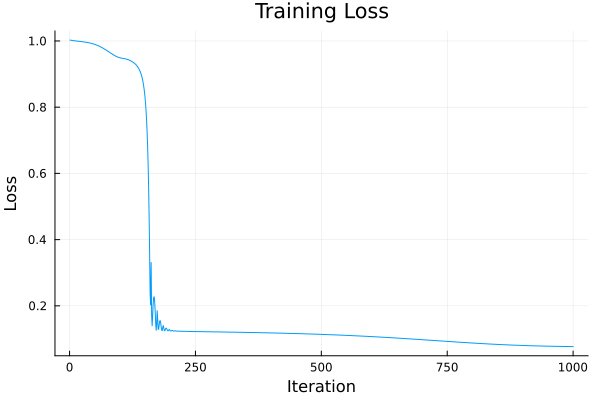

In [106]:
plot(losses, xlabel="Iteration", ylabel="Loss", title="Training Loss", legend=false)

In [107]:
function r_squared(y, y_hat)
    ss_res = sum((y .- y_hat).^2)
    ss_tot = sum((y .- mean(y)).^2)
    return 1 - ss_res / ss_tot
end

r_squared (generic function with 1 method)

In [108]:
y_train_hat = simulate(params, u)
y_train_hat = y_train_hat .* y_std .+  y_mean # denormalize the output 

1×1024 Matrix{Float64}:
 3.69249  4.76014  4.82687  4.88212  …  3.85114  3.9082  3.96754  4.0287

In [109]:
mse = mean((y_train .- y_train_hat).^2, dims=2)
rmse = sqrt.(mse)

1×1 Matrix{Float64}:
 0.6003224494176225

In [110]:
r_squared(y_train, y_train_hat)

0.9231225409109772

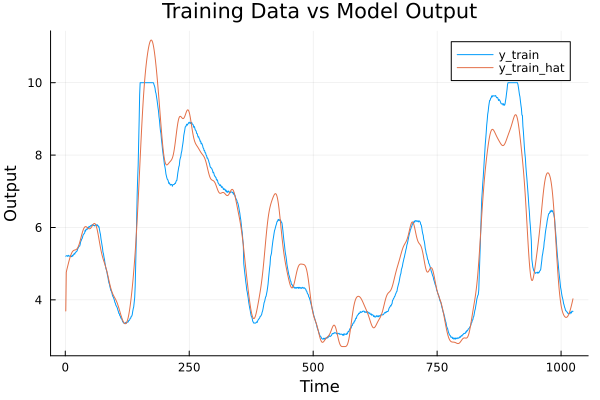

In [111]:
plot(1:size(y_train, 2), y_train[1, :], label="y_train", xlabel="Time", ylabel="Output", title="Training Data vs Model Output")
plot!(1:size(y_train_hat, 2), y_train_hat[1, :], label="y_train_hat")

In [112]:
u_test_norm = (u_test .- u_mean) ./ u_std
y_test_hat = simulate(params, u_test_norm)
y_test_hat = y_test_hat .* y_std .+ y_mean  # denormalize the output 

1×1024 Matrix{Float64}:
 3.69249  5.70749  5.57494  5.42293  …  3.50238  3.36992  3.23793  3.1091

In [113]:
mse = mean((y_test .- y_test_hat).^2, dims=2)
rmse = sqrt.(mse)

1×1 Matrix{Float64}:
 0.669182229290726

In [114]:
r_squared(y_test, y_test_hat)

0.89839251040226

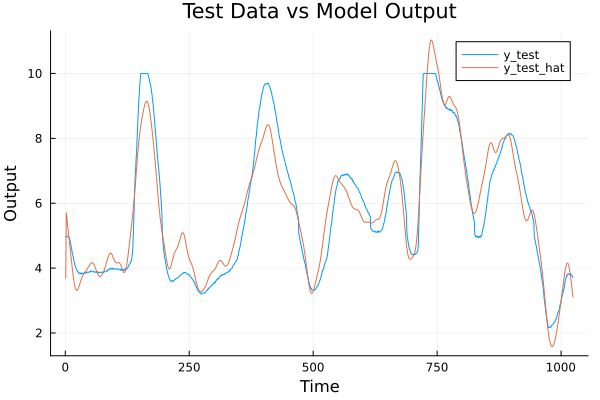

In [115]:
plot(1:size(y_test, 2), y_test[1, :], label="y_test", xlabel="Time", ylabel="Output", title="Test Data vs Model Output")
plot!(1:size(y_test_hat, 2), y_test_hat[1, :], label="y_test_hat")